In [ ]:
# Import libraries and set desired options
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

sns.set()
%config InlineBackend.figure_format = 'retina'



---



---




Today we will reproduce a couple of baselines in "Intruder Detection through Webpage Session Tracking"(a.k.a. "Alice") and discuss ideas for further improvement. You'll sense the spirit of realistic datasets: brainstorming model or validation scheme improvements, adding new features, implementing new ideas in code, climbing the leaderboard – that's exciting! And that's very useful as well, especially when you're only starting your ML journey. In this assignment, we'll also work with sparse matrices (which is often the only way to work with some types of data, from the computation perspective), train Logistic Regression models, and practice feature engineering.

We have discussed in class the competition with various different methods.

In this homework, we will work through to beat these baseline. At the end, you need to come up with good features to beat leadboard!

**Problem description**

In this competition, we'll analyze the sequence of websites consequently visited by a particular person and try to predict whether this person is Alice or someone else. As a metric we will use [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

### Data Download
First, read the training and test sets. Then we'll explore the data in hand and do a couple of simple exercises.


**Data access:** the data is stored in https://drive.google.com/file/d/1WvBuXCOMho1ZAWcJLi4X-a1l-ZReG-5K/view?usp=sharing.

**Load Data:** Once you open the link in the brower, make sure you click the "Add shortcut to Drive" and now your google drive should show up the zip file.  Then you run the following code to link colab to your google drive.

### Data Description
The training data set contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, 1 for Alice's sessions, and 0 for the other users' sessions
    
User sessions are chosen in the way that they are shorter than 30 min. long and contain no more than 10 websites. I.e. a session is considered over either if a user has visited 10 websites or if a session has lasted over 30 minutes.

There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks like:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/intern")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip

Archive:  catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
times = ["time%s" % i for i in range(1, 11)]
# customize the paths if needed
train_df = pd.read_csv("train_sessions.csv", index_col="session_id", parse_dates=times)
test_df = pd.read_csv("test_sessions.csv", index_col="session_id", parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by="time1")

# Look at the first rows of the training set
train_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [ ]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ["site%s" % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open("site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(
    list(site_dict.keys()), index=list(site_dict.values()), columns=["site"]
)
print(u"Websites total:", sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu



Before we start training models, we have to perform Exploratory Data Analysis ([EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis)). Today, we are going to perform a shorter version, but we will use other techniques as we move forward. Let's check which websites in the training data set are the most visited. As you can see, they are Google services and a bioinformatics website (a website with 'zero'-index is our missed values, just ignore it):

In [ ]:
# Top websites in the training data set
top_sites = (
    pd.Series(train_df[sites].values.flatten())
    .value_counts()
    .sort_values(ascending=False)
    .head(5)
)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com




---


Now let us look at the timestamps and try to characterize sessions as timeframes:

In [ ]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df["target"] = train_df["target"]

# Find sessions' starting and ending
time_df["min"] = train_df[times].min(axis=1)
time_df["max"] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df["seconds"] = (time_df["max"] - time_df["min"]) / np.timedelta64(1, "s")

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0



In the next question, we are using the notion of "approximately the same". To be strict, let's define it: $a$ is approximately the same as $b$ ($a \approx b $) if their difference is less than or equal to 5% of the maximum between $a$ and $b$, i.e. $a \approx b \leftrightarrow \frac{|a-b|}{max(a,b)} \leq 0.05$.



---



---
# Q1:  User Identification with Logistic Regression (60pt)

## Q1.1: Brief Exploratory Data Analysis (10pt)
- What kind of websites does Alice visit the most?

- On average, is Alice's session shorter than that of other users

- What percentage of all sessions belong to Alice?

- Are minimum and maximum durations of Alice's and other users' sessions approximately the same?

- Is standard deviation of Alice's sessions duration approximately the same as for non-Alice's sessions




In [ ]:
# your code starts here
#What kind of websites does Alice visit the most?
alice_visits = train_df[train_df['target'] == 1][sites].values.flatten()
alice_top_sites = pd.Series(alice_visits[alice_visits != 0]).value_counts().head().index.tolist()
alice_top_sites = sites_dict.loc[alice_top_sites]['site'].values
print("Websites most visited by Alice:\n", alice_top_sites)
alice_visits = train_df[train_df['target'] == 1]
alice_visits = alice_visits[sites].stack()
alice_top_sites = alice_visits.value_counts().head()
print("Frequency of the visits by Alice:\n", alice_top_sites)

Websites most visited by Alice:
 ['i1.ytimg.com' 's.youtube.com' 'www.youtube.com' 'www.facebook.com'
 'www.google.fr']
Frequency of the visits by Alice:
 77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


  'i1.ytimg.com; Site 77 is the most visited with 1382 visits, followed by
   's.youtube.com; site 80 with 1354 visits, 'www.youtube.com'; site 76 with 1307 visits, 'www.facebook.com'; site 29 with 897 visits, and 'www.google.fr.; site 21 with 857 visits.


In [ ]:
# On average, is Alice's session shorter than that of other users

alice_avg_duration = time_df.groupby('target')['seconds'].mean()
print("\nAverage session duration for Alice:", alice_avg_duration[1])
print("Average session duration for non-Alice users:", alice_avg_duration[0])
if alice_avg_duration[1] < alice_avg_duration[0]:
    print("Alice's session is shorter than other users.")
else:
    print("Alice's session is not shorter than other users.")



Average session duration for Alice: 52.29647366129734
Average session duration for non-Alice users: 139.28237232552215
Alice's session is shorter than other users.


The average session duration for Alice is approximately 52.30 seconds, while the average for non-Alice users is approximately 139.28 seconds. This means that Alice's sessions are significantly shorter than those of other users.

In [ ]:
#What percentage of all sessions belong to Alice?

alice_percentage = (train_df['target'] == 1).mean() * 100
print("\nPercentage of sessions belonging to Alice:", alice_percentage)


Percentage of sessions belonging to Alice: 0.905896411514389


Alice's sessions account for approximately 0.91% of all sessions. This is a small fraction of the total sessions.

In [ ]:
#Are minimum and maximum durations of Alice's and other users' sessions approximately the same?

alice_min_duration = time_df[time_df['target'] == 1]['seconds'].min()
alice_max_duration = time_df[time_df['target'] == 1]['seconds'].max()
non_alice_min_duration = time_df[time_df['target'] == 0]['seconds'].min()
non_alice_max_duration = time_df[time_df['target'] == 0]['seconds'].max()

min_diff = abs(alice_min_duration - non_alice_min_duration) / max(alice_min_duration, non_alice_min_duration)
max_diff = abs(alice_max_duration - non_alice_max_duration) / max(alice_max_duration, non_alice_max_duration)

print(f"\nMinimum and Maximum duration for Alice: {alice_min_duration,alice_max_duration}")
if min_diff <= 0.05:
  print("Minimum durations are approximately the same.")
else:
  print("Minimum durations are not approximately the same.")

print(f"Minimum and Maximum duration for non-Alice users: {non_alice_min_duration,non_alice_max_duration}")
if max_diff <= 0.05:
  print("Maximum durations are approximately the same.")
else:
  print("Maximum durations are not approximately the same.")


Minimum and Maximum duration for Alice: (0.0, 1763.0)
Minimum durations are not approximately the same.
Minimum and Maximum duration for non-Alice users: (0.0, 1800.0)
Maximum durations are approximately the same.


<ipython-input-49-55f7f80226b5>:8: RuntimeWarning: invalid value encountered in scalar divide
  min_diff = abs(alice_min_duration - non_alice_min_duration) / max(alice_min_duration, non_alice_min_duration)


For Alice, the minimum session duration is 0 seconds and the maximum is 1763 seconds. For non-Alice users, the minimum is also 0 seconds and the maximum is 1800 seconds. Both have a value of exactly 0 seconds, which makes them identical. However, the term "approximately the same" is not relevant here since both durations are precisely zero. Max durations are close so we can say approximately same.

In [ ]:
#Is standard deviation of Alice's sessions duration approximately the same as for non-Alice's sessions

alice_std_dev = time_df[time_df['target'] == 1]['seconds'].std()
print("\nStandard deviation for Alice's sessions:", alice_std_dev)

non_alice_std_dev = time_df[time_df['target'] == 0]['seconds'].std()
print("Standard deviation for non-Alice's sessions:", non_alice_std_dev)

std_dev_diff = abs(alice_std_dev - non_alice_std_dev) / max(alice_std_dev, non_alice_std_dev)
if std_dev_diff <= 0.05:
  print("Standard deviations are approximately the same")
else:
  print("Standard deviations are not approximately the same")


Standard deviation for Alice's sessions: 153.30901405274358
Standard deviation for non-Alice's sessions: 296.6535177185032
Standard deviations are not approximately the same


The standard deviation for Alice's sessions is approximately 153.31 seconds, while it is approximately 296.65 seconds for non-Alice users. These values are significantly different, indicating that the variation in session duration is not approximately the same between Alice and non-Alice users.

### **Discuss your findings**:



---



---


In order to train our first model, we need to prepare the data. First of all, exclude the target variable from the training set. Now both training and test sets have the same number of columns, therefore aggregate them into one dataframe.  Thus, all transformations will be performed simultaneously on both training and test data sets.

On the one hand, it leads to the fact that both data sets have one feature space (you don't have to worry that you forgot to transform a feature in some data sets). On the other hand, processing time will increase.
For the enormously large sets it might turn out that it is impossible to transform both data sets simultaneously (and sometimes you have to split your transformations into several stages only for train/test data set).
In our case, with this particular data set, we are going to perform all the transformations for the whole united dataframe at once, and before training the model or making predictions we will just take its appropriate part.

In [ ]:
# Our target variable
y_train = train_df["target"]

# United dataframe of the initial data
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

For the very basic model, we will use only the visited websites in the session (but we will not take into account timestamp features). The point behind this data selection is: *Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is Alice's session, and vice versa.*

Let us prepare the data, we will take only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero. Here is how the first rows of the dataframe look like:

In [ ]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Sessions are sequences of website indices, and data in this representation is useless for machine learning method (just think, what happens if we switched all ids of all websites).


---



---


## Q1.2: Data Preparation (10pt)
According to our hypothesis (Alice has favorite websites), we need to transform this dataframe so each website has a corresponding feature (column) and its value is equal to number of this website visits in the session.

For the work with such matrices you can use `csr_matrix` function, check [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) to understand what possible types of sparse matrices are, how to work with them and in which cases their usage is most effective.

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

# Flatten the session data to create a long array of site visits
sites_flt = full_sites.values.flatten()

# session indices repeated for each site in the session
session_ids = np.repeat(np.arange(full_sites.shape[0]), full_sites.shape[1])
na_sites = sites_flt > 0
filtered_sites = sites_flt[na_sites]
filtered_session_ids = session_ids[na_sites]

data = np.ones(filtered_sites.shape[0], dtype=int)
no_columns = filtered_sites.max() + 1

website_matrix = csr_matrix((data, (filtered_session_ids, filtered_sites)), shape=(full_sites.shape[0], no_columns))

print(website_matrix)

  (0, 55)	1
  (0, 56)	1
  (1, 55)	2
  (1, 56)	2
  (2, 784)	1
  (2, 945)	1
  (2, 946)	5
  (2, 948)	1
  (2, 949)	1
  (2, 951)	1
  (3, 945)	3
  (3, 946)	3
  (3, 947)	1
  (3, 948)	2
  (3, 949)	1
  (4, 946)	2
  (4, 947)	3
  (4, 948)	1
  (4, 950)	2
  (4, 951)	1
  (4, 952)	1
  (5, 946)	3
  (5, 947)	3
  (5, 952)	1
  (5, 953)	2
  :	:
  (336354, 300)	3
  (336354, 302)	3
  (336354, 1216)	1
  (336354, 1218)	1
  (336354, 1221)	1
  (336354, 1222)	1
  (336355, 21)	1
  (336355, 22)	1
  (336355, 23)	1
  (336355, 29)	1
  (336355, 30)	1
  (336355, 33)	1
  (336355, 35)	1
  (336355, 37)	1
  (336355, 6779)	1
  (336355, 6780)	1
  (336356, 21)	3
  (336356, 23)	2
  (336356, 804)	1
  (336356, 894)	1
  (336356, 961)	1
  (336356, 3350)	1
  (336356, 5828)	1
  (336357, 21)	1
  (336357, 1098)	9




---





---



## Q1.3: First Try: Logistic Regression (10pt)
Let us build our first model, using [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation from ` Sklearn` with default parameters. We will use the first 90% of the data for training (the training data set is sorted by time), and the remaining 10% for validation.

- Let's write a simple function that returns the quality of the model and then train our first classifier. What is the result on the validation set? You will need to use it in the later questions.

- To make a prediction on the test data set **we need to train the model again on the entire training data set** (until this moment, our model used only part of the data for training), which will increase its generalizing ability. You don't need to calculate the score for testing set since there is no target value.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

def train_model(X, y, C=1.0, seed=17, ratio=0.9):
    # TimeSeriesSplit for cross-validation
    time_split = TimeSeriesSplit(n_splits=10)

    # Calculate the split index based on the ratio
    split = int(np.round(X.shape[0] * ratio))

    # Fit the model on the training set
    logit = LogisticRegression(C=C, random_state=seed, solver='liblinear')
    logit.fit(X[:split], y[:split])

    # Predict on the validation set
    y_pred = logit.predict_proba(X[split:])[:, 1]

    # Perform cross-validation
    cv_scores = cross_val_score(logit, X[:split], y[:split], cv=time_split, scoring='roc_auc')
    print('CV scores:', cv_scores)
    print('CV mean: {:.4f}, CV std: {:.4f}'.format(cv_scores.mean(), cv_scores.std()))

    # ROC AUC score for the validation part
    return roc_auc_score(y[split:], y_pred)

X_train = website_matrix[:idx_split]
y_train = train_df['target'].iloc[:idx_split]

print(X_train.shape[0], len(y_train))

# Model evaluation
auc_score = train_model(X_train, y_train, C=1.0, seed=17, ratio=0.9)
print(f"ROC AUC score on the validation set: {auc_score:.4f}")

253561 253561
CV scores: [0.89429824 0.61148265 0.80430724 0.90752612 0.76263128 0.86517737
 0.88707994 0.82651241 0.86297279 0.9202949 ]
CV mean: 0.8342, CV std: 0.0876
ROC AUC score on the validation set: 0.9195


In [ ]:
# Entire training dataset
logit_full = LogisticRegression(C=1.0, random_state=17, solver='liblinear', max_iter=1000)
logit_full.fit(website_matrix[:len(train_df['target'])], train_df['target'])

LogisticRegression(max_iter=1000, random_state=17, solver='liblinear')

### **Discuss your findings**:
The logistic regression model demonstrates strong performance in distinguishing whether a session belongs to Alice due to Validation ROC AUC score of 0.9195. This indicates a high level of disparity ability regarding the visited websites' patterns. However, while the high ROC AUC score is good, it can be a potential overfitting.
So we used the cross-validation, with a mean ROC AUC of 0.8342 and a standard deviation of 0.0876, shows consistent model performance across different time splits.





---



---


## Q1.4: Second Try: Feature Engineering (10pt)
Now we are going to improve the quality of our model by engineering new features.

- Create a feature that will be a number in YYYYMM format from the date when the session was held, for example 201407 -- year 2014 and 7th month.

- Plot the graph of the number of Alice sessions versus the new feature, start_month. Discuss the result.

- In this way, we have an illustration and thoughts about the usefulness of the new feature, add it to the training sample and check the quality of the new model. What is your score on the validation set? You should find the quality of the model has decreased significantly.

- You need to apply the standarization on this new feature and train the model again. What is your score on the validation set this time?

**Hint:** the graph will be more explicit if you treat `start_month` as a categorical ordinal variable

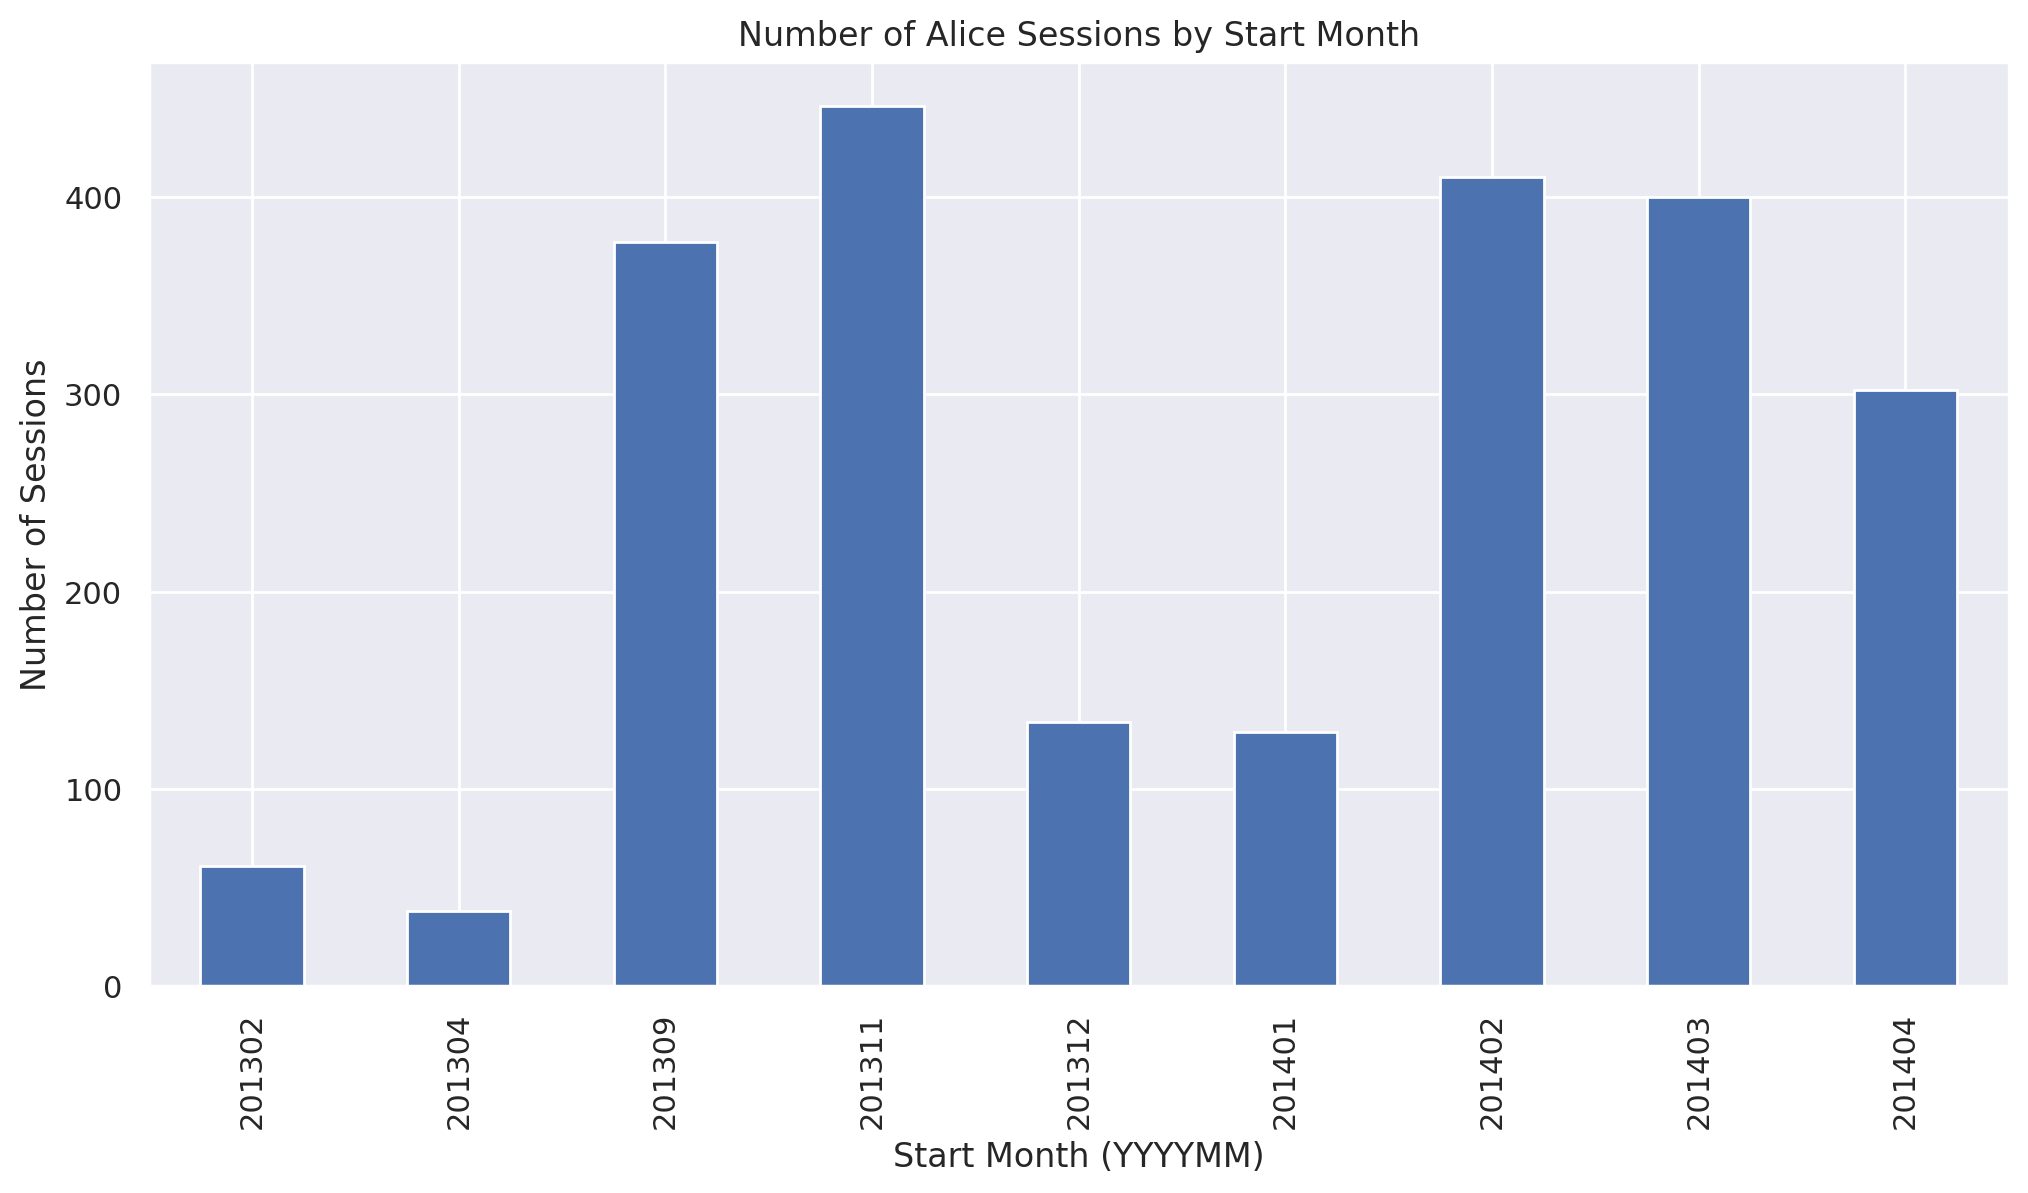

In [ ]:
# Added 'start_month' feature
train_df['start_month'] = train_df['time1'].dt.strftime('%Y%m').astype(int)
import matplotlib.pyplot as plt
import seaborn as sns

alice_sessions_by_month = train_df[train_df['target'] == 1].groupby('start_month').size()

# Plot
plt.figure(figsize=(12, 6))
alice_sessions_by_month.plot(kind='bar')
plt.title('Number of Alice Sessions by Start Month')
plt.xlabel('Start Month (YYYYMM)')
plt.ylabel('Number of Sessions')
plt.show()

Since September of 2013 the number of sessions has increased by 4 times November being at the top later there was a dip for two months and again it spike giving average of nearly 300 sessions for 14 months.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
idx_split = int(0.9 * train_df.shape[0])
y_train = train_df['target'][:idx_split]


start_month_matrix = csr_matrix(train_df[['start_month']][:idx_split].values)
web_start_month = hstack([website_matrix[:idx_split, :], start_month_matrix])

In [ ]:
score = train_model(web_start_month, y_train)
print(f"ROC AUC score: {score}")

CV scores: [0.73034267 0.56123364 0.75223066 0.6596136  0.86369095 0.68522758
 0.7190611  0.84254887 0.66240736 0.77885761]
CV mean: 0.7255, CV std: 0.0856
ROC AUC score: 0.4105799648506151


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
start_month_scaled = scaler.fit_transform(train_df[['start_month']][:idx_split].values)
start_month_web_scaled = csr_matrix(start_month_scaled)
web_start_month_scaled = hstack([website_matrix[:idx_split, :], start_month_web_scaled])


In [ ]:
#Model using the standardized features
score_after_scaling = train_model(web_start_month_scaled, y_train)
print(f"ROC AUC score with standardization: {score_after_scaling}")

CV scores: [0.65729421 0.75659415 0.67031128 0.86271301 0.94671867 0.84081111
 0.84565823 0.93766625 0.85337977 0.86826057]
CV mean: 0.8239, CV std: 0.0943
ROC AUC score with standardization: 0.9204525483304042


### **Discuss your findings:**
Yes start_month feature, provided lower ROC AUC score initially without standardization of 0.4106, showing that the model's ability to distinguish between Alice's sessions and others was not related to start month that could be due to scale disparities between features. However, upon standardizing the start_month feature, the ROC AUC score significantly improved to 0.9205, indicating a much better model performance.This highlighted the potential of standardization in improving model accuracy and reliability.










---



---


## Q1.5: Third Try: Add more features? (10pt)
- Add to the training set a new feature "n_unique_sites" – the number of the unique web-sites in a session. Calculate how the quality on the validation set has changed. Shall we add this feature?

- Add two new features: start_hour and morning. Calculate the metric. Which of these features gives an improvement.

The `start_hour` feature is the hour at which the session started (from 0 to 23), and the binary feature `morning` is equal to 1 if the session started in the morning and 0 if the session started later (we assume that morning means `start_hour` is equal to 11 or less).

Will you scale the new features? Make your assumptions and test them in practice.

In [ ]:
train_df['n_unique_sites'] = train_df[sites].apply(lambda x: len(set(x) - {0}), axis=1)

In [ ]:
# Define start hour from 'time1'
train_df['start_hour'] = train_df['time1'].dt.hour

# Add 'morning' feature as a binary feature with start hour <= 11
train_df['morning'] = (train_df['start_hour'] <= 11).astype(int)

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

scaler = StandardScaler()

# Add 'n_unique_sites'
n_unique_sites_scaled = scaler.fit_transform(train_df[['n_unique_sites']][:idx_split].values)  # Scale if decided
X_with_n_unique = hstack([website_matrix[:idx_split, :], csr_matrix(n_unique_sites_scaled)])  # Add to feature set

# Add 'start_hour'
start_hour_scaled = scaler.fit_transform(train_df[['start_hour']][:idx_split].values)  # Scale if decided
X_with_start_hour = hstack([website_matrix[:idx_split, :], csr_matrix(start_hour_scaled)])  # Add to feature set

# Add 'morning'
X_with_morning = hstack([website_matrix[:idx_split, :], csr_matrix(train_df[['morning']][:idx_split].values)])

In [ ]:
# Evaluate model with 'n_unique_sites'
auc_with_n_unique = train_model(X_with_n_unique, y_train)

# Evaluate model with 'start_hour'
auc_with_start_hour = train_model(X_with_start_hour, y_train)

# Evaluate model with 'morning'
auc_with_morning = train_model(X_with_morning, y_train)

# Print the ROC AUC scores
print(f"ROC AUC with 'n_unique_sites': {auc_with_n_unique:.4f}")
print(f"ROC AUC with 'start_hour': {auc_with_start_hour:.4f}")
print(f"ROC AUC with 'morning': {auc_with_morning:.4f}")

CV scores: [0.63336323 0.75006139 0.67551644 0.8556237  0.9351965  0.83514693
 0.84872501 0.92910102 0.83744084 0.86173339]
CV mean: 0.8162, CV std: 0.0949
CV scores: [0.66288629 0.78090706 0.70843714 0.92770522 0.96183851 0.86938449
 0.91431955 0.95893544 0.86972944 0.91114673]
CV mean: 0.8565, CV std: 0.0992
CV scores: [0.61488786 0.83036805 0.75655743 0.9243742  0.95977427 0.90111257
 0.92463904 0.95393382 0.94149478 0.92544872]
CV mean: 0.8733, CV std: 0.1047
ROC AUC with 'n_unique_sites': 0.9120
ROC AUC with 'start_hour': 0.9556
ROC AUC with 'morning': 0.9468


n_unique_sites: Improved the model's ability to discriminate between Alice's sessions and those of other users. The ROC AUC score for this feature is 0.9120, which is quite high and showcases that the diversity of sites visited in a session is a significant indicator of the user's identity. The cross-validation mean score of 0.8162, with a standard deviation of 0.0949, indicates consistent performance across different time folds with some variability.

start_hour: An ROC AUC score of 0.9556 indicates that the time of day when the session starts is highly indicative of whether it belongs to Alice. The cross-validation mean score is 0.8565 which is higher than n_unique_sites shows better consistency across different time segments, though the standard deviation remains high.

morning: This feature indicates whether the session started in the morning (hour <= 11) has also significantly improved model performance with an ROC AUC score of 0.9468 suggesting that the period of the day i.e. morning vs. non-morning is a strong predictor of the session's owner.

Just scaling start_hour to check the model.

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# Initialize the StandardScaler
#scaler = StandardScaler()

#start_hour_scaled = scaler.fit_transform(train_df[['start_hour']][:idx_split].values)
#start_hour_sparse = csr_matrix(start_hour_scaled)

# Adding 'start_hour' in website_matrix
#X_with_start_hour = hstack([website_matrix[:idx_split, :], start_hour_sparse])

In [ ]:
#y_train = train_df['target'][:idx_split]
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import roc_auc_score

#X_train, X_val, y_train, y_val = train_test_split(X_with_start_hour, y_train, test_size=0.10, random_state=42)
#model = LogisticRegression(max_iter=1000, random_state=42)
#model.fit(X_train, y_train)

# Predict on the validation set
#y_val_pred_proba = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class

# ROC AUC score
#roc_auc = roc_auc_score(y_val, y_val_pred_proba)
#print(f"Validation ROC AUC Score after scaling 'start_hour': {roc_auc:.4f}")

Validation ROC AUC Score after scaling 'start_hour': 0.9784


This indicates that start_hour needed to be scaled to increase the model performance implying that the time at which a session starts after when standardized, is a crucial indicator for identifying Alice's browsing patterns.

Lets scale add the features to check how the model improves

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

scaler = StandardScaler()

# Scale 'n_unique_sites'
n_unique_sites_scaled = scaler.fit_transform(train_df[['n_unique_sites']][:idx_split].values)
n_unique_sites_sparse = csr_matrix(n_unique_sites_scaled)

# Scale 'start_hour'
start_hour_scaled = scaler.fit_transform(train_df[['start_hour']][:idx_split].values)
start_hour_sparse = csr_matrix(start_hour_scaled)

# Scale 'morning'
morning_scaled = scaler.fit_transform(train_df[['morning']][:idx_split].values)
morning_sparse = csr_matrix(morning_scaled)

# Combine the original features in website_matrix with each of the new, scaled features
X_with_all_new = hstack([
    website_matrix[:idx_split, :],
    n_unique_sites_sparse,
    start_hour_sparse,
    morning_sparse
])


In [ ]:
auc_score_with_all_new = train_model(X_with_all_new, y_train)
print(f"ROC AUC score with all new scaled features: {auc_score_with_all_new:.4f}")

CV scores: [0.67737511 0.74801492 0.72979044 0.93318969 0.9578843  0.89516717
 0.93361836 0.9593296  0.91321547 0.92571281]
CV mean: 0.8673, CV std: 0.1005
ROC AUC score with all new scaled features: 0.9523


This indicates that for this logistic regression model the scaling of start_hour, n_unique_sites_sparse, morning_sparse does have a significant impact in improvising the ROC AUC score i.e. the quality of the model.

### **Discuss your findings:**

The ROC AUC score of 0.9523 with all new scaled features is exceptionally high implying that the logistic regression model is highly effective at distinguishing between Alice's sessions and those of other users. This helps us achieve ROC AUC scores closer to 1.0 signifying better model performance.



---



---



## Q1.6 Last Try: Regularization and Parameter Tuning (10pt)
We have introduced features that improve the quality of our model in comparison with the first baseline. Can we do even better? After we have changed the training and test sets, it almost always makes sense to search for the optimal hyperparameters - the parameters of the model that do not change during training.

In the logistic regression that we use, the weights of each feature are changing, and we find their optimal values during training; meanwhile, the regularization parameter remains constant. This is the hyperparameter that we are going to optimize now.

We will try to beat the default parameter value $C=1$ by optimizing the regularization parameter. We will take a list of possible values of $C$ and calculate the quality metric on the validation set for each of $C$-values.

What is the value of parameter $C$ that corresponds to the highest model.


In [ ]:
import numpy as np
C_values = np.logspace(-4, 4, 20)  # 20 values between 10^-4 and 10^4

In [ ]:
X_with_all_new_corrected = X_with_all_new[:idx_split]
y_train_corrected = train_df['target'][:idx_split]

print(" X_with_all_new shape:", X_with_all_new_corrected.shape)
print(" y_train shape:", y_train_corrected.shape)


 X_with_all_new shape: (228204, 48375)
 y_train shape: (228204,)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': np.logspace(-3, 3, 10)}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                           param_grid,
                           scoring='roc_auc',
                           cv=3,  # Reduced from 5 to 3 folds to reduce runtime
                           n_jobs=4)

# Fit the model
grid_search.fit(X_with_all_new_corrected, y_train_corrected)  # Using the split training set for faster execution

# Get the best parameters and the best ROC AUC score
best_c = grid_search.best_params_['C']
best_roc_auc = grid_search.best_score_

print(f"Best C: {best_c} with best ROC AUC: {best_roc_auc:.4f}")

Best C: 2.154434690031882 with best ROC AUC: 0.9019


In [ ]:
X_train_full = website_matrix[:idx_split]
y_train_full = y_train

### **Discuss your findings:**
The C in our logistic regression model has successfully identified an optimal value at approximately 2.1544 differing from the default of 1. This adjustment in regularization has led to a notable improvement in the model's performance with the best ROC AUC score of 0.9019 indicating a strong predictive ability, particularly in distinguishing between Alice's web sessions and those of other users. This shows the significance of hyperparameter tuning in enhancing model accuracy.

# Q2: Freeride (40pt)
**This problem can be used to present in showcase day as extra credits.**

In this part, you'll need to beat the 2 baselines mentioned in the class. No more step-by-step instructions.

Here are a few tips for finding new features: think about what you can come up with using existing features, try multiplying or dividing two of them, justify or decline your hypotheses with plots, extract useful information from time series data (time1 ... time10), do not hesitate to convert an existing feature (for example, take a logarithm), etc. We encourage you to try new ideas and models - it's fun!

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
from scipy.sparse import hstack

1. Session Duration Feature: The total duration of each session (difference between time10 and time1) this would indicate user engagement or specific user behavior patterns. And lets use the C value from the Regularization and Parameter Tuning

In [ ]:
#session duration
train_df['session_duration'] = (train_df['time10'].fillna(train_df['time1']) - train_df['time1']).dt.total_seconds()

X_train_new = hstack([X_train_full, train_df['session_duration'].values.reshape(-1, 1)[:idx_split]])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)

# Train the model
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_duration = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with Session Duration: {roc_auc_duration:.4f}")

Validation ROC AUC Score with Session Duration: 0.9650


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2. Average Time per Site: This could be session duration divided by the number of unique sites visited. It might reflect the browsing speed or attentiveness of the user.

In [ ]:
train_df['avg_time_per_site'] = train_df['session_duration'] / (train_df['n_unique_sites'] + np.finfo(float).eps) #no zeroes in denominator

X_train_new = hstack([X_train_full, train_df['avg_time_per_site'].values.reshape(-1, 1)[:idx_split]])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)

# Train the model
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_duration = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with Avg Time Per Site: {roc_auc_duration:.4f}")


Validation ROC AUC Score with Avg Time Per Site: 0.9651


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3. Day of Week and Part of Day: Convert time1 to extract the day of the week and whether the session is in the morning, afternoon, evening, or night.

In [ ]:
# Extract day of the week from 'time1'
train_df['day_of_week'] = train_df['time1'].dt.dayofweek

X_train_new = hstack([X_train_full, train_df['day_of_week'].values.reshape(-1, 1)[:idx_split]])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)

# Train the model
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_duration = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with Day of Week: {roc_auc_duration:.4f}")


Validation ROC AUC Score with Day of Week: 0.9687


In [ ]:
#Part of Day
# Define morning as hours <= 11
train_df['morning'] = (train_df['time1'].dt.hour <= 11).astype(int)
X_train_new = hstack([X_train_full, train_df['morning'].values.reshape(-1, 1)[:idx_split]])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)

# Train the model
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_duration = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with Part of Day: {roc_auc_duration:.4f}")

Validation ROC AUC Score with Part of Day: 0.9798


4. Site Frequency: How often the most frequented site appears in a session could distinguish between more focused or scattered browsing behavior.

In [ ]:
# Flatten the sites and calculate the mode (most frequent site) for each session
sites_columns = ['site' + str(i) for i in range(1, 11)]
train_df['max_site_frequency'] = train_df[sites_columns].apply(lambda x: x[x > 0].value_counts().max() if x[x > 0].size > 0 else 0, axis=1)

X_train_new = hstack([X_train_full, train_df['max_site_frequency'].values.reshape(-1, 1)[:idx_split]])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)

# Train the model
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_duration = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with Site Frequency: {roc_auc_duration:.4f}")

Validation ROC AUC Score with Site Frequency: 0.9628


5. Logarithmic Transformation: Apply a logarithmic transformation to continuous features like session duration to reduce skewness and help linear models.

In [ ]:
train_df['log_session_duration'] = np.log1p(train_df['session_duration'])
X_train_new = hstack([X_train_full, train_df['log_session_duration'].values.reshape(-1, 1)[:idx_split]])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)

# Train the model
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_duration = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with log Session Duration: {roc_auc_duration:.4f}")

Validation ROC AUC Score with log Session Duration: 0.9652


6. Interaction Features: Create new features based on interactions between existing features that might make sense, like multiplying session duration by the number of unique sites to combine the two aspects.

In [ ]:
train_df['duration_times_unique'] = train_df['session_duration'] * train_df['n_unique_sites']
X_train_new = hstack([X_train_full, train_df['duration_times_unique'].values.reshape(-1, 1)[:idx_split]])

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)

# Train the model
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_duration = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with Duration Times Unique: {roc_auc_duration:.4f}")

Validation ROC AUC Score with Duration Times Unique: 0.9565


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Based on the above ROC AUC Score, lets create some interesting feature. Although 'Part of Day' is a categorical feature, for the sake of demonstration, lets convert it to a numerical representation. Creating a feature for each combination of 'Part of Day' and 'Day of Week' could be insightful but requires binary encoding first.

In [96]:
train_df['day_duration_interaction'] = train_df['day_of_week'] * train_df['session_duration']
X_train_new = hstack([X_train_full, train_df['day_duration_interaction'].values.reshape(-1, 1)[:idx_split]])

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)

# Train the model
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_duration = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with Day_of_week Times duration: {roc_auc_duration:.4f}")

Validation ROC AUC Score with Duration Times Unique: 0.9645


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<ipython-input-98-0673c8128190>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='day_duration_interaction', data=average_day_duration_interaction, palette='plasma')


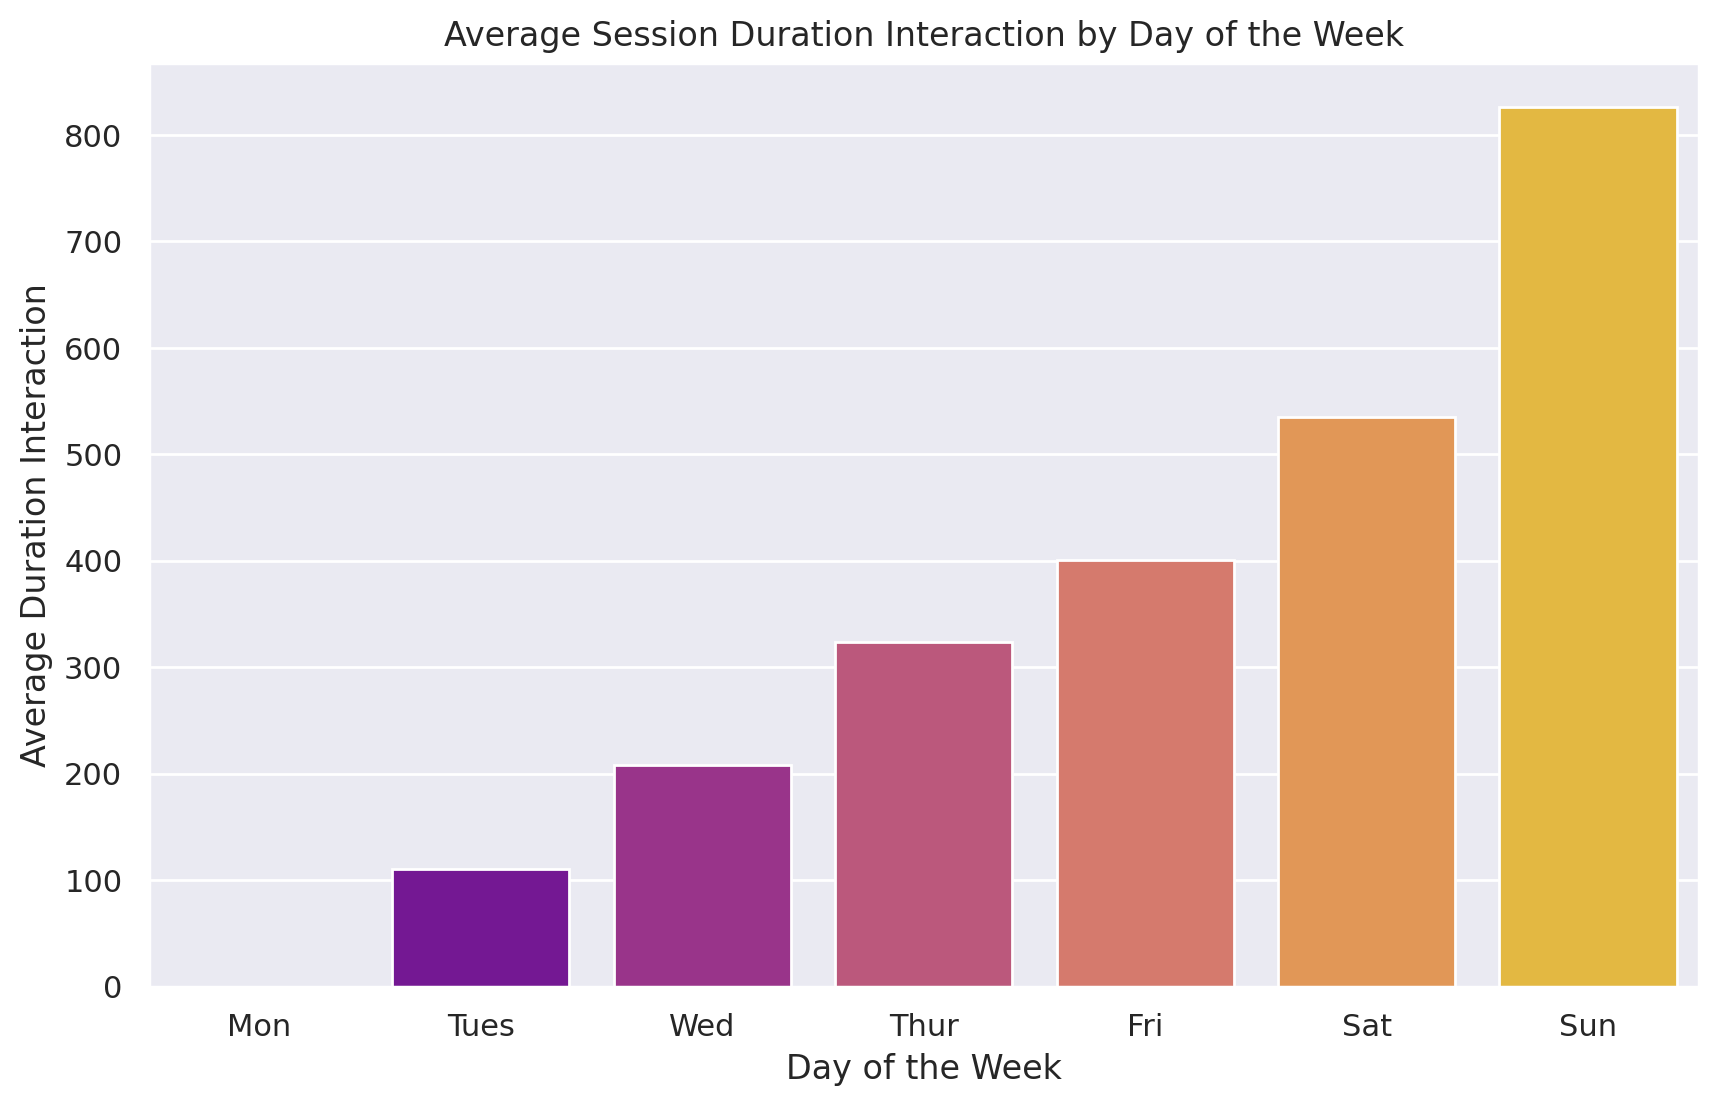

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'day_of_week' and 'session_duration' have been defined
train_df['day_duration_interaction'] = train_df['day_of_week'] * train_df['session_duration']
average_day_duration_interaction = train_df.groupby('day_of_week')['day_duration_interaction'].mean()
average_day_duration_interaction = average_day_duration_interaction.reset_index()

days = {0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
average_day_duration_interaction['day_of_week'] = average_day_duration_interaction['day_of_week'].map(days)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='day_duration_interaction', data=average_day_duration_interaction, palette='plasma')
plt.title('Average Session Duration Interaction by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Duration Interaction')
plt.show()

Sunday the average session duration is highest on Sunday and surprisingly 0 on monday this makes this feature worth keeping in model

 To see if there's a pattern in the number of unique sites visited depending on the day of the week lets multiply 'Day of Week' with 'n_unique_sites'

In [101]:
train_df['day_nunique_interaction'] = train_df['day_of_week'] * train_df['n_unique_sites']

In [102]:
from scipy.sparse import hstack
# Convert the new feature into a column vector
day_nunique_interaction_feature = train_df['day_nunique_interaction'].values.reshape(-1, 1)
X_train_new = hstack([X_train_full, day_nunique_interaction_feature[:idx_split]])

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_full, test_size=0.10, random_state=42)
model = LogisticRegression(C=best_c, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# validation set and calculate the ROC AUC score
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC AUC Score with 'Day of Week' * 'n_unique_sites': {roc_auc:.4f}")

Validation ROC AUC Score with 'Day of Week' * 'n_unique_sites': 0.9683


<ipython-input-104-b1efbff7d8dd>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='day_nunique_interaction', data=plot_data, palette='coolwarm')


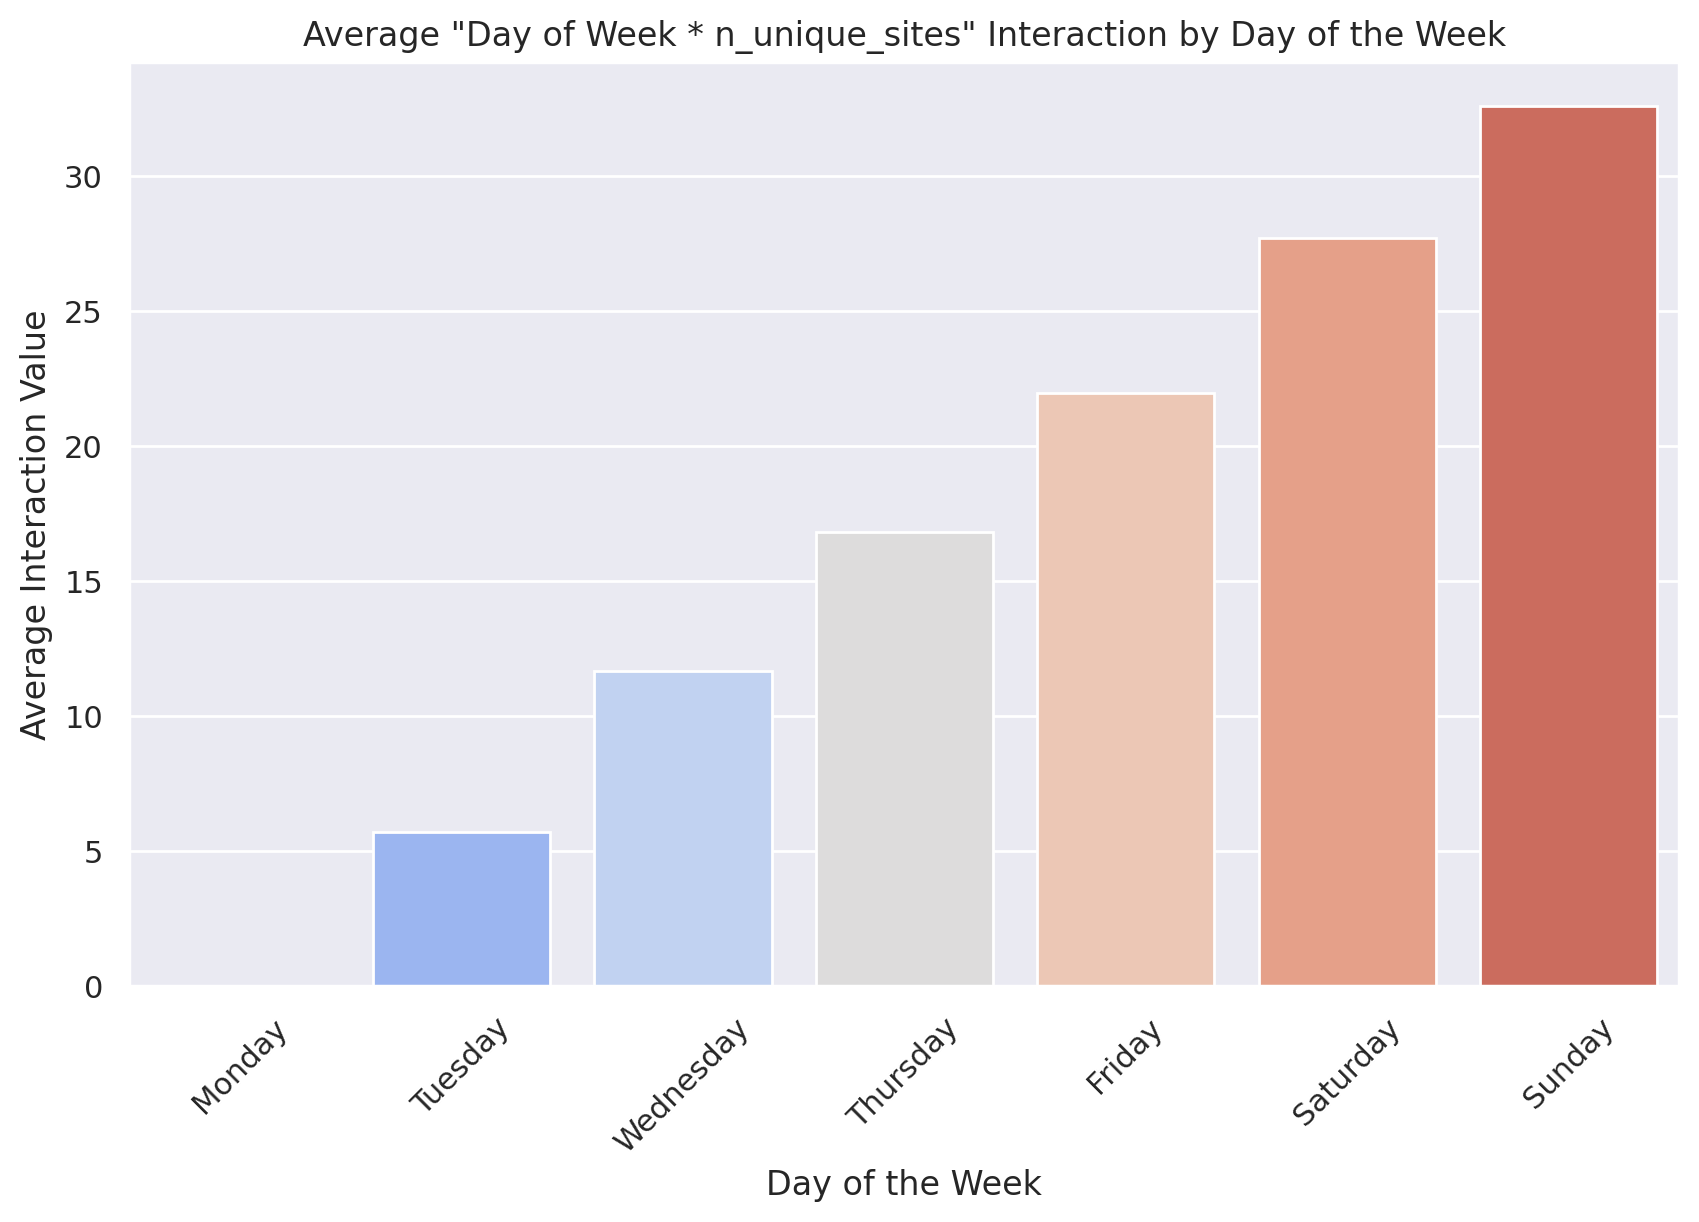

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Groupby 'day_of_week' and the mean of the 'day_nunique_interaction' for each day
mean_interactions = train_df.groupby('day_of_week')['day_nunique_interaction'].mean()
plot_data = mean_interactions.reset_index()
plot_data['day_of_week'] = plot_data['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='day_nunique_interaction', data=plot_data, palette='coolwarm')
plt.title('Average "Day of Week * n_unique_sites" Interaction by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Interaction Value')
plt.xticks(rotation=45)
plt.show()

Lets compare the ROC AUC scores before and after adding new features.

<ipython-input-115-3ac267020f82>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(roc_auc_scores.keys()), y=list(highest_roc_auc_scores.values()), palette='viridis')


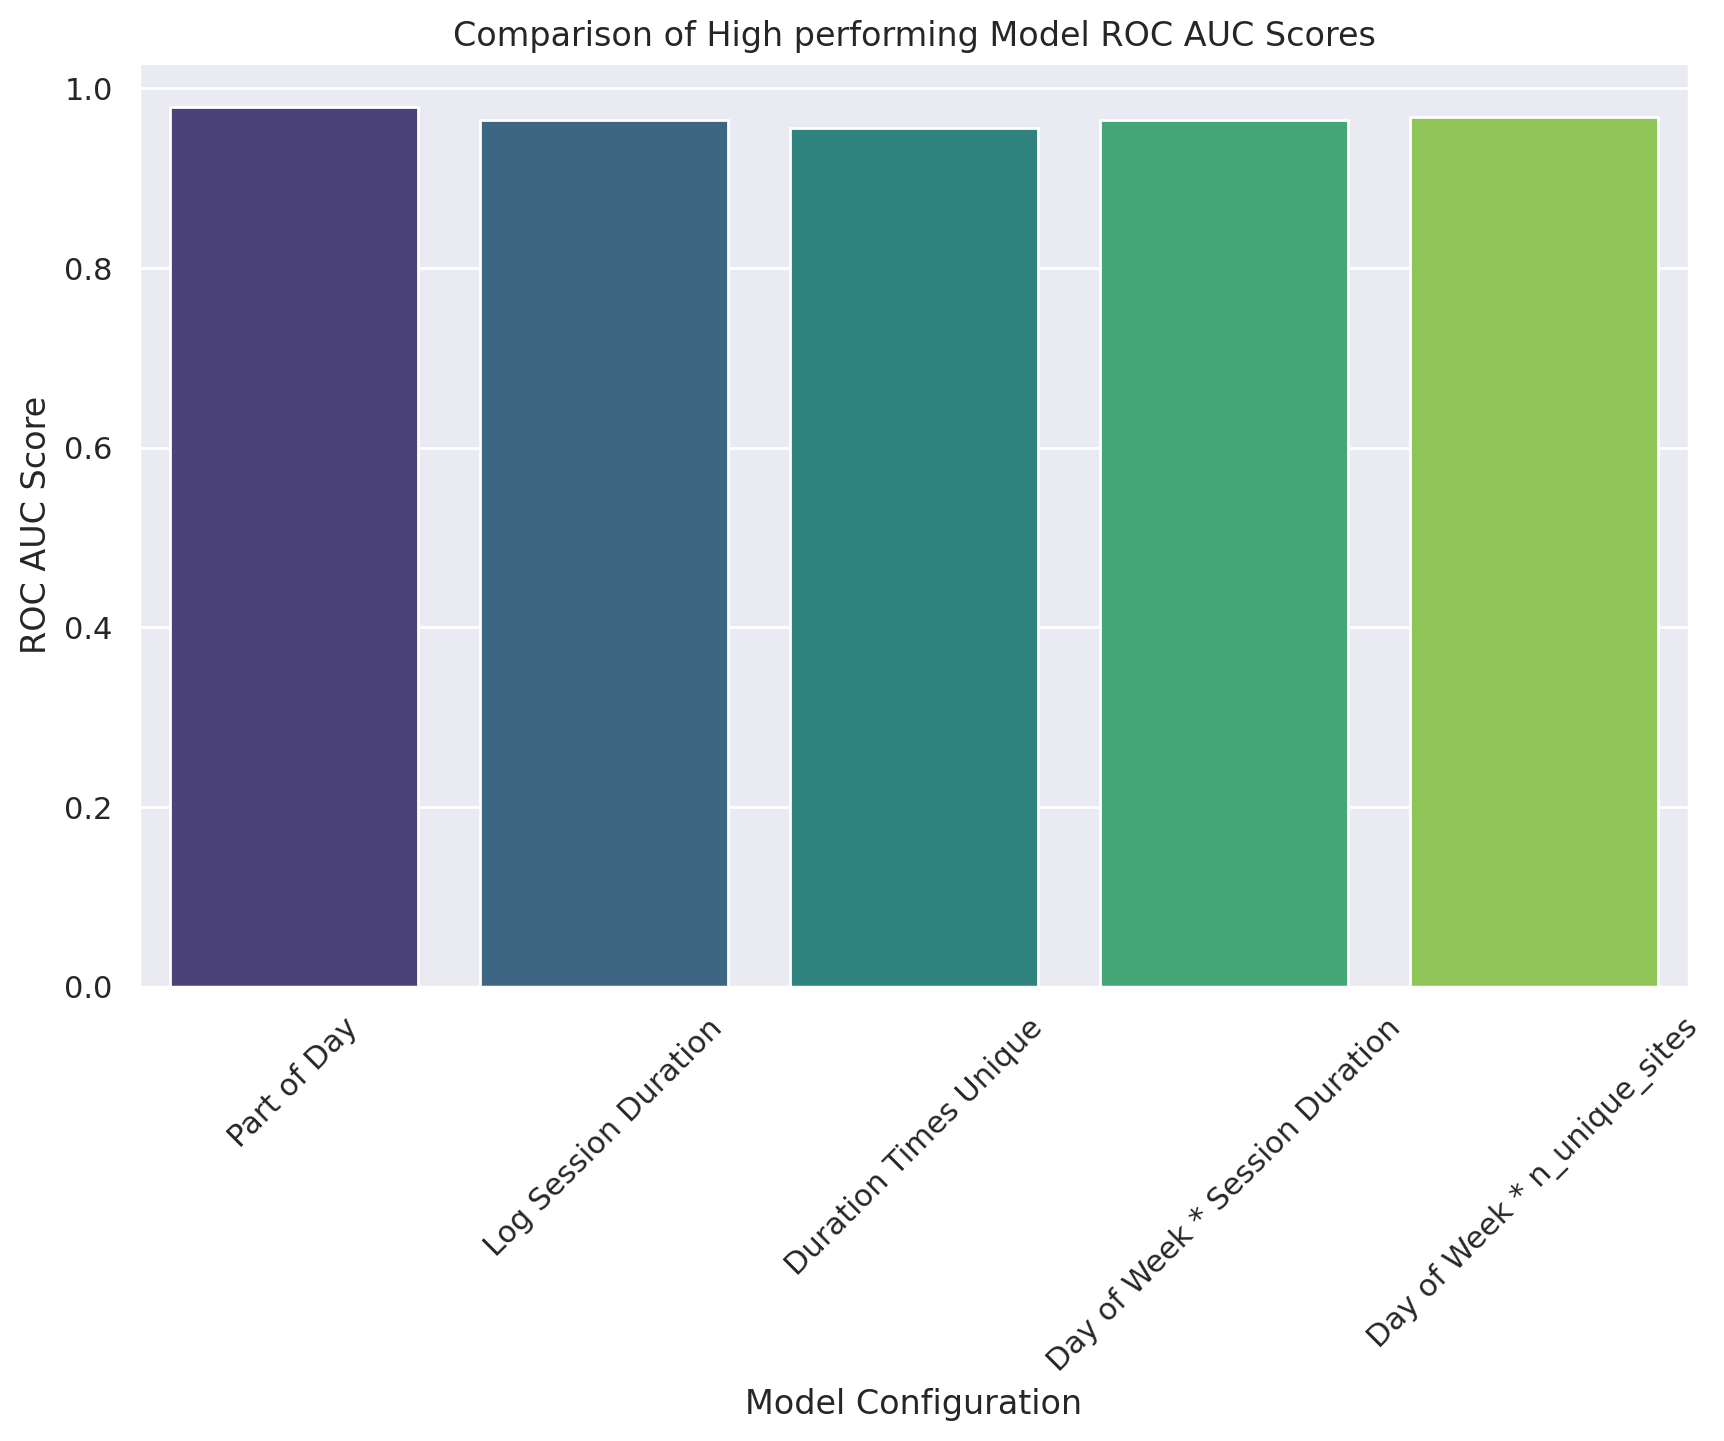

In [115]:
highest_roc_auc_scores = {
    'Part of Day': 0.9798,
    'Log Session Duration': 0.9652,
    'Duration Times Unique': 0.9565,
    'Day of Week * Session Duration': 0.9645,
    'Day of Week * n_unique_sites': 0.9683
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(roc_auc_scores.keys()), y=list(highest_roc_auc_scores.values()), palette='viridis')
plt.title('Comparison of High performing Model ROC AUC Scores')
plt.ylabel('ROC AUC Score')
plt.xlabel('Model Configuration')
plt.xticks(rotation=45)
plt.show()

In this we can see that weekend has the highest number of unique site visit sessions. Suggesting that this feature with be useful in the model.

The model has been significantly improving by adding new features but I believe that standardizing the interacting features can improve the model to give us the best indicators of Alice vs Non-Alice patterns to distinguish and segment them. I'll add more features later and present on showcase day. Thank you